# BTC News Impact Predictor — CNN + BiLSTM
## Binary Classification: Predict Next-Day BTC Price Direction (UP / DOWN)

**Architecture:** Multi-kernel CNN + Bidirectional LSTM + Self-Attention + TF-IDF LSA branch  
**Target:** F1-macro > 0.60 on held-out test set  
**No data leakage** — all preprocessors fit on train split only

---

### Pipeline

| Step | Description |
|------|-------------|
| 1 | Imports & seeds |
| 2 | FocalLoss with label smoothing |
| 3 | Data loading & leakage guard |
| 4 | Extended feature engineering |
| 5 | Stratified date-based split |
| 6 | Text augmentation (train only) |
| 7 | Preprocessing (tokenizer + TF-IDF + scaler) |
| 8 | Model architecture |
| 9 | Training |
| 10 | Learning curves |
| 11 | Threshold optimization |
| 12 | Final evaluation |
| 13 | Evaluation plots |
| 14 | Artifact saving |
| 15 | Inference class |
| 16 | FastAPI skeleton |


## 1. Imports & Seeds

In [1]:
# !pip install tensorflow scikit-learn pandas numpy joblib matplotlib seaborn

import os
import re
import json
import random
import warnings

import joblib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing           import LabelEncoder, StandardScaler
from sklearn.utils.class_weight      import compute_class_weight
from sklearn.model_selection         import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition           import TruncatedSVD
from sklearn.metrics                 import (
    accuracy_score, f1_score, roc_auc_score,
    roc_curve, confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score,
)

import tensorflow as tf
import keras

from tensorflow.keras.preprocessing.text     import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models                 import Model, load_model
from tensorflow.keras.layers                 import (
    Input, Embedding, Conv1D,
    GlobalMaxPooling1D, GlobalAveragePooling1D,
    LSTM, Bidirectional,
    Dense, Dropout, Flatten, Concatenate,
    SpatialDropout1D, LayerNormalization, BatchNormalization,
    Activation, RepeatVector, Permute, Multiply, Add,
    MultiHeadAttention,
)
from tensorflow.keras.callbacks  import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
)
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings("ignore")

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print(f"TensorFlow : {tf.__version__}")
print(f"Keras      : {keras.__version__}")
print(f"GPU        : {bool(tf.config.list_physical_devices('GPU'))}")
print("Imports OK")


TensorFlow : 2.20.0
Keras      : 3.13.2
GPU        : False
Imports OK


## 2. FocalLoss with Label Smoothing

**Label smoothing** (ε=0.05) prevents overconfidence on small datasets by softening hard targets.  
Combined with Focal Loss it handles both class imbalance and calibration simultaneously.

```
FL(p_t) = alpha_t * (1 - p_t)^gamma * BCE(p_t)
y_smooth = y * (1 - ε) + 0.5 * ε
```

In [2]:
class FocalLoss(keras.losses.Loss):
    """
    Focal Loss with integrated label smoothing for binary classification.

    Parameters
    ----------
    gamma : float
        Focusing parameter — higher values down-weight easy examples more.
    alpha : float
        Class weight for the positive class (label = 1).
    label_smoothing : float
        Smoothing factor. 0 = no smoothing (standard focal loss).
    """

    def __init__(
        self,
        gamma           : float = 2.0,
        alpha           : float = 0.6,
        label_smoothing : float = 0.05,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.gamma           = gamma
        self.alpha           = alpha
        self.label_smoothing = label_smoothing

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # Apply label smoothing
        y_smooth = y_true * (1.0 - self.label_smoothing) + 0.5 * self.label_smoothing
        y_pred   = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        bce = (
            -y_smooth * tf.math.log(y_pred)
            - (1.0 - y_smooth) * tf.math.log(1.0 - y_pred)
        )
        # Use original (hard) labels for the focusing factor
        p_t = tf.where(tf.cast(y_true, tf.bool), y_pred, 1.0 - y_pred)
        alpha_t = tf.where(
            tf.cast(y_true, tf.bool),
            tf.ones_like(y_true) * self.alpha,
            tf.ones_like(y_true) * (1.0 - self.alpha),
        )
        return tf.reduce_mean(alpha_t * tf.pow(1.0 - p_t, self.gamma) * bce)

    def get_config(self):
        cfg = super().get_config()
        cfg.update({
            "gamma"          : self.gamma,
            "alpha"          : self.alpha,
            "label_smoothing": self.label_smoothing,
        })
        return cfg


focal_loss = FocalLoss(gamma=2.0, alpha=0.6, label_smoothing=0.05, name="focal_loss")
print(f"FocalLoss — gamma={focal_loss.gamma} | alpha={focal_loss.alpha} | "
      f"label_smoothing={focal_loss.label_smoothing}")
print("load_model() requires: custom_objects={'FocalLoss': FocalLoss}")


FocalLoss — gamma=2.0 | alpha=0.6 | label_smoothing=0.05
load_model() requires: custom_objects={'FocalLoss': FocalLoss}


## 3. Data Loading & Leakage Guard

In [3]:
CSV_PATH = "../data/raw/btc_news.csv"

df = pd.read_csv(CSV_PATH)

# Drop leakage columns that encode the target label
LEAKAGE_COLS = ["price_next_day", "price_change_next_day"]
dropped = [c for c in LEAKAGE_COLS if c in df.columns]
df = df.drop(columns=dropped)
print(f"Leakage columns dropped: {dropped}")

# Type coercion & cleaning
df = df.dropna(subset=["text_clean", "label", "date"])
df = df[df["text_clean"].str.strip() != ""]

df["sentiment_score"]  = pd.to_numeric(df["sentiment_score"],  errors="coerce").fillna(0.0)
df["price_change_24h"] = pd.to_numeric(df["price_change_24h"], errors="coerce").fillna(0.0)
df["price"]            = pd.to_numeric(df["price"],            errors="coerce")
df["price"]            = df["price"].fillna(df["price"].median())
df["severity"]         = (
    pd.to_numeric(df["severity"], errors="coerce")
    .fillna(1).clip(1, 10).astype(int)
)
df["category"] = df["category"].fillna("OTHER")
df["label"]    = df["label"].astype(int)
df["date"]     = pd.to_datetime(df["date"]).dt.strftime("%Y-%m-%d")
df             = df.sort_values("date").reset_index(drop=True)

print(f"\nDataset    : {len(df):,} articles")
print(f"Dates      : {df['date'].nunique()} unique trading days")
print(f"Date range : {df['date'].min()} → {df['date'].max()}")
print(f"Label      : UP={df['label'].mean():.2%}  |  DOWN={1 - df['label'].mean():.2%}")
print(f"Columns    : {list(df.columns)}")
print("\nCategory distribution:")
print(df["category"].value_counts().to_string())
if "source" in df.columns:
    print("\nTop sources:")
    print(df["source"].value_counts().head(8).to_string())


Leakage columns dropped: ['price_next_day', 'price_change_next_day']

Dataset    : 2,575 articles
Dates      : 50 unique trading days
Date range : 2025-10-15 → 2026-02-20
Label      : UP=39.65%  |  DOWN=60.35%
Columns    : ['event_id', 'timestamp', 'date', 'title', 'text_clean', 'source', 'url', 'category', 'sentiment_score', 'price', 'price_change_24h', 'label', 'severity']

Category distribution:
category
REGULATORY    753
MARKET        723
OTHER         521
MACRO         206
TECH          181
ADOPTION      154
SECURITY       37

Top sources:
source
Cointelegraph    367
Benzinga         286
newsBTC          200
Motley Fool      181
Bitcoinist       143
CoinDesk         100
Decrypt.co        97
U.Today           97


## 4. Feature Engineering

All daily aggregates use **same-day data only** — no future information leaks in.

| Feature | Description |
|---------|-------------|
| `volume_news` | Article count that day |
| `avg_sentiment` | Mean daily sentiment |
| `std_sentiment` | Sentiment dispersion |
| `avg_price_change` | Mean 24h price change |
| `max_severity` | Highest severity that day |
| `avg_severity` | Mean severity |
| `news_momentum` | 3-day rolling article volume |
| `sent_momentum` | 3-day rolling sentiment |
| `sent_volatility` | 5-day rolling sentiment std |
| `volume_accel` | Day-over-day volume change |
| `log_price` | Log-scaled BTC price |
| `neg_news_ratio` | Fraction of negative articles |
| `pos_news_ratio` | Fraction of positive articles |
| `sentiment_range` | Max − Min sentiment |
| `sent_trend_5d` | 5-day sentiment slope |
| `price_sent_x` | log_price × avg_sentiment |
| `is_weekend` | Weekend flag |
| `is_monday` | Monday flag |
| `is_friday` | Friday flag |

In [4]:
CATEGORIES = ["REGULATORY", "SECURITY", "MACRO", "TECH", "ADOPTION", "MARKET", "OTHER"]

# Source encoding
if "source" in df.columns:
    df["source_clean"] = df["source"].str.extract(r"([^/]+)$").fillna("Unknown")
    top_sources        = df["source_clean"].value_counts().head(6).index.tolist()
    df["source_clean"] = df["source_clean"].apply(
        lambda x: x if x in top_sources else "Other"
    )
    SOURCES = sorted(df["source_clean"].unique().tolist())
    print(f"Sources ({len(SOURCES)}): {SOURCES}")
else:
    df["source_clean"] = "Unknown"
    SOURCES = ["Unknown"]

# Sentiment polarity flags
df["is_negative"] = (df["sentiment_score"] < -0.1).astype(float)
df["is_positive"] = (df["sentiment_score"] >  0.1).astype(float)

# Daily aggregates
daily = df.groupby("date").agg(
    volume_news      = ("sentiment_score", "count"),
    avg_sentiment    = ("sentiment_score", "mean"),
    std_sentiment    = ("sentiment_score", "std"),
    avg_price_change = ("price_change_24h", "mean"),
    max_severity     = ("severity", "max"),
    avg_severity     = ("severity", "mean"),
    avg_price        = ("price", "mean"),
    neg_news_ratio   = ("is_negative", "mean"),
    pos_news_ratio   = ("is_positive", "mean"),
    sentiment_range  = ("sentiment_score", lambda x: x.max() - x.min()),
    max_sentiment    = ("sentiment_score", "max"),
    min_sentiment    = ("sentiment_score", "min"),
).reset_index()

daily["std_sentiment"]   = daily["std_sentiment"].fillna(0.0)
daily["news_momentum"]   = daily["volume_news"].rolling(3, min_periods=1).mean()
daily["sent_momentum"]   = daily["avg_sentiment"].rolling(3, min_periods=1).mean()
daily["sent_volatility"] = daily["avg_sentiment"].rolling(5, min_periods=1).std().fillna(0.0)
daily["volume_accel"]    = daily["volume_news"].diff().fillna(0.0)
daily["log_price"]       = np.log1p(daily["avg_price"])

# 5-day sentiment trend (linear slope)
daily["sent_trend_5d"] = (
    daily["avg_sentiment"]
    .rolling(5, min_periods=2)
    .apply(lambda x: np.polyfit(range(len(x)), x, 1)[0] if len(x) > 1 else 0.0, raw=True)
    .fillna(0.0)
)

# Price × sentiment interaction
daily["price_sent_x"] = daily["log_price"] * daily["avg_sentiment"]

# Calendar features (BTC has notable weekend/weekday patterns)
daily["date_dt"]  = pd.to_datetime(daily["date"])
daily["weekday"]  = daily["date_dt"].dt.weekday
daily["is_weekend"] = (daily["weekday"] >= 5).astype(float)
daily["is_monday"]  = (daily["weekday"] == 0).astype(float)
daily["is_friday"]  = (daily["weekday"] == 4).astype(float)

df = df.merge(daily, on="date", how="left")

# Text enrichment — inject metadata tokens into text
def sentiment_label(score: float) -> str:
    if   score >  0.3: return "very_positive"
    elif score >  0.1: return "positive"
    elif score < -0.3: return "very_negative"
    elif score < -0.1: return "negative"
    else:              return "neutral"

def severity_label(s: int) -> str:
    if   s >= 8: return "critical_event"
    elif s >= 5: return "major_event"
    else:        return "minor_event"

df["text_enriched"] = (
    df["text_clean"] + " "
    + df["category"].str.lower() + " "
    + df["sentiment_score"].apply(sentiment_label) + " "
    + df["severity"].apply(severity_label)
)

DAILY_FEATURE_COLS = [
    "volume_news", "avg_sentiment", "std_sentiment", "avg_price_change",
    "max_severity", "avg_severity", "news_momentum", "sent_momentum",
    "sent_volatility", "volume_accel", "log_price",
    "neg_news_ratio", "pos_news_ratio", "sentiment_range",
    "max_sentiment", "min_sentiment",
    "sent_trend_5d", "price_sent_x",
    "is_weekend", "is_monday", "is_friday",
]

print(f"\nDaily features: {len(DAILY_FEATURE_COLS)}")
print(daily[DAILY_FEATURE_COLS].describe().round(3).to_string())


Sources (7): ['Benzinga', 'Bitcoinist', 'CoinDesk', 'Cointelegraph', 'Motley Fool', 'Other', 'newsBTC']

Daily features: 21
       volume_news  avg_sentiment  std_sentiment  avg_price_change  max_severity  avg_severity  news_momentum  sent_momentum  sent_volatility  volume_accel  log_price  neg_news_ratio  pos_news_ratio  sentiment_range  max_sentiment  min_sentiment  sent_trend_5d  price_sent_x  is_weekend  is_monday  is_friday
count        50.00         50.000         50.000            50.000        50.000        50.000         50.000         50.000           50.000        50.000     50.000          50.000          50.000           50.000         50.000         50.000         50.000        50.000      50.000      50.00     50.000
mean         51.50          0.086          0.121            -0.444         2.040         2.040         47.573          0.091            0.055         2.880     11.310           0.071           0.411            0.649          0.411         -0.238         -0.0

## 5. Stratified Date-Based Split

All articles from the same date stay in the same split — prevents subtle temporal leakage.
Stratified on the majority label of each date.

In [5]:
unique_dates = np.array(sorted(df["date"].unique()))
n_dates      = len(unique_dates)

date_to_label = df.groupby("date")["label"].mean().apply(lambda x: 1 if x >= 0.5 else 0)
date_labels   = np.array([date_to_label[d] for d in unique_dates])

print(f"Total dates   : {n_dates}")
print(f"UP-dominant   : {date_labels.sum()} days ({date_labels.mean():.1%})")
print(f"DOWN-dominant : {n_dates - date_labels.sum()} days ({1 - date_labels.mean():.1%})")

# Step 1: 80% train+val / 20% test
dates_trainval, dates_test, labels_trainval, _ = train_test_split(
    unique_dates, date_labels,
    test_size=0.20, random_state=42, stratify=date_labels,
)

# Step 2: 75% train / 25% val from train+val
dates_train, dates_val = train_test_split(
    dates_trainval, test_size=0.25,
    random_state=42, stratify=labels_trainval,
)

idx_train = df[df["date"].isin(dates_train)].index.values
idx_val   = df[df["date"].isin(dates_val)].index.values
idx_test  = df[df["date"].isin(dates_test)].index.values

y_train = df["label"].values[idx_train]
y_val   = df["label"].values[idx_val]
y_test  = df["label"].values[idx_test]

print(f"\n{'─'*68}")
print(f"{'Set':<8} {'Dates':>6} {'Articles':>10} {'Art/date':>10} {'UP%':>8}")
print(f"{'─'*68}")
for name, idx, dates, y in [
    ("Train", idx_train, dates_train, y_train),
    ("Val",   idx_val,   dates_val,   y_val),
    ("Test",  idx_test,  dates_test,  y_test),
]:
    print(f"{name:<8} {len(dates):>6} {len(idx):>10,} "
          f"{len(idx)/len(dates):>10.1f} {y.mean():>8.2%}")
print(f"{'─'*68}")

shift_tv = abs(y_train.mean() - y_val.mean())
shift_tt = abs(y_train.mean() - y_test.mean())
print(f"\nLabel shift Train↔Val  : {shift_tv:.3f}  {'OK' if shift_tv < 0.10 else '> 0.10 (expected with 50 dates)'}")
print(f"Label shift Train↔Test : {shift_tt:.3f}  {'OK' if shift_tt < 0.10 else '> 0.10 (expected with 50 dates)'}")


Total dates   : 50
UP-dominant   : 18 days (36.0%)
DOWN-dominant : 32 days (64.0%)

────────────────────────────────────────────────────────────────────
Set       Dates   Articles   Art/date      UP%
────────────────────────────────────────────────────────────────────
Train        30      1,875       62.5   38.35%
Val          10        324       32.4   11.11%
Test         10        376       37.6   70.74%
────────────────────────────────────────────────────────────────────

Label shift Train↔Val  : 0.272  > 0.10 (expected with 50 dates)
Label shift Train↔Test : 0.324  > 0.10 (expected with 50 dates)


## 6. Text Augmentation (Train Only)

Word dropout augmentation applied only to training data — avoids any leakage from val/test.  
Randomly drops ~10% of words per article to create a noisy variant, effectively doubling the training set.

In [6]:
def word_dropout(text: str, p_drop: float = 0.10, seed: int = None) -> str:
    """Drop each word independently with probability p_drop."""
    if seed is not None:
        random.seed(seed)
    words = text.split()
    words = [w for w in words if random.random() > p_drop]
    return " ".join(words) if words else text


texts_train_orig  = df["text_enriched"].values[idx_train]
labels_train_orig = y_train.copy()

# Create one augmented copy per article
aug_texts  = np.array([word_dropout(t, p_drop=0.10, seed=i) for i, t in enumerate(texts_train_orig)])
aug_labels = labels_train_orig.copy()

# Concatenate originals + augmented
texts_train_aug  = np.concatenate([texts_train_orig, aug_texts])
labels_train_aug = np.concatenate([labels_train_orig, aug_labels])

print(f"Train before augmentation : {len(texts_train_orig):,} articles")
print(f"Train after  augmentation : {len(texts_train_aug):,} articles")
print(f"  UP%  : {labels_train_aug.mean():.2%}")
print(f"  DOWN%: {1 - labels_train_aug.mean():.2%}")


Train before augmentation : 1,875 articles
Train after  augmentation : 3,750 articles
  UP%  : 38.35%
  DOWN%: 61.65%


## 7. Preprocessing — Tokenizer + TF-IDF LSA + Scaler

Three input modalities:
1. **Sequence** — integer-tokenized text for the CNN+BiLSTM branch
2. **TF-IDF LSA** — 100-dimensional latent semantic features for the TF-IDF branch  
3. **Numeric** — scaled continuous features + one-hot encodings for the numeric branch

All transformers (tokenizer, TF-IDF, SVD, scaler) are **fit on the training split only**.

In [7]:
CONTINUOUS_COLS = [
    "sentiment_score",    # article-level sentiment [-1, 1]
    "price_change_24h",   # BTC 24h price change (%)
    "severity",           # article severity [1, 10]
    # Daily features:
    "volume_news", "avg_sentiment", "std_sentiment", "avg_price_change",
    "max_severity", "avg_severity", "news_momentum", "sent_momentum",
    "sent_volatility", "volume_accel", "log_price",
    "neg_news_ratio", "pos_news_ratio", "sentiment_range",
    "max_sentiment", "min_sentiment",
    "sent_trend_5d", "price_sent_x",
    "is_weekend", "is_monday", "is_friday",
]

# ── One-hot encoding ──────────────────────────────────────────────────────────
le_cat  = LabelEncoder().fit(CATEGORIES)
cat_enc = le_cat.transform(df["category"].apply(lambda x: x if x in CATEGORIES else "OTHER"))
cat_ohe = tf.keras.utils.to_categorical(cat_enc, num_classes=len(CATEGORIES))

le_src  = LabelEncoder().fit(SOURCES)
src_enc = le_src.transform(df["source_clean"])
src_ohe = tf.keras.utils.to_categorical(src_enc, num_classes=len(SOURCES))

texts          = df["text_enriched"].values
labels         = df["label"].values
continuous_raw = df[CONTINUOUS_COLS].fillna(0).values.astype(np.float32)

# StandardScaler — fit on train only
scaler     = StandardScaler()
cont_train = scaler.fit_transform(continuous_raw[idx_train])
cont_val   = scaler.transform(continuous_raw[idx_val])
cont_test  = scaler.transform(continuous_raw[idx_test])

X_num_train = np.hstack([cont_train, cat_ohe[idx_train], src_ohe[idx_train]]).astype(np.float32)
X_num_val   = np.hstack([cont_val,   cat_ohe[idx_val],   src_ohe[idx_val]]).astype(np.float32)
X_num_test  = np.hstack([cont_test,  cat_ohe[idx_test],  src_ohe[idx_test]]).astype(np.float32)
NUM_DIM     = X_num_train.shape[1]

# ── Tokenizer — fit on train only ─────────────────────────────────────────────
MAX_VOCAB  = 25_000
MAX_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>", lower=True)
tokenizer.fit_on_texts(texts[idx_train])   # fit on original train texts only

X_text_train = pad_sequences(
    tokenizer.texts_to_sequences(texts_train_aug),  # encode augmented set
    maxlen=MAX_LENGTH, padding="post", truncating="post",
)
X_text_val = pad_sequences(
    tokenizer.texts_to_sequences(texts[idx_val]),
    maxlen=MAX_LENGTH, padding="post", truncating="post",
)
X_text_test = pad_sequences(
    tokenizer.texts_to_sequences(texts[idx_test]),
    maxlen=MAX_LENGTH, padding="post", truncating="post",
)

# Duplicate numeric features to match augmented train size
X_num_train_aug = np.vstack([X_num_train, X_num_train])
y_train_aug     = labels_train_aug

# ── TF-IDF + Truncated SVD (LSA) — fit on train only ─────────────────────────
TFIDF_DIM = 100

print("Computing TF-IDF + LSA features...")
tfidf = TfidfVectorizer(
    max_features=10_000,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.95,
    sublinear_tf=True,
)
tfidf_train_raw = tfidf.fit_transform(texts[idx_train])   # fit on originals
tfidf_val_raw   = tfidf.transform(texts[idx_val])
tfidf_test_raw  = tfidf.transform(texts[idx_test])

svd = TruncatedSVD(n_components=TFIDF_DIM, random_state=SEED)
tfidf_train_lsa = svd.fit_transform(tfidf_train_raw).astype(np.float32)
tfidf_val_lsa   = svd.transform(tfidf_val_raw).astype(np.float32)
tfidf_test_lsa  = svd.transform(tfidf_test_raw).astype(np.float32)

tfidf_scaler = StandardScaler()
tfidf_train_lsa = tfidf_scaler.fit_transform(tfidf_train_lsa).astype(np.float32)
tfidf_val_lsa   = tfidf_scaler.transform(tfidf_val_lsa).astype(np.float32)
tfidf_test_lsa  = tfidf_scaler.transform(tfidf_test_lsa).astype(np.float32)

# Duplicate TF-IDF for augmented train set
tfidf_train_aug = np.vstack([tfidf_train_lsa, tfidf_train_lsa])

print(f"Numeric input dim  : {NUM_DIM} "
      f"({len(CONTINUOUS_COLS)} continuous + {len(CATEGORIES)} cat OHE + {len(SOURCES)} src OHE)")
print(f"TF-IDF LSA dim     : {TFIDF_DIM}")
print(f"Vocabulary (train) : {min(len(tokenizer.word_index), MAX_VOCAB):,}")
print(f"Sequence length    : {MAX_LENGTH} tokens")
print(f"X_text_train shape : {X_text_train.shape}  (with augmentation)")
print(f"X_num_train  shape : {X_num_train_aug.shape}")
print(f"tfidf_train  shape : {tfidf_train_aug.shape}")


Computing TF-IDF + LSA features...
Numeric input dim  : 38 (24 continuous + 7 cat OHE + 7 src OHE)
TF-IDF LSA dim     : 100
Vocabulary (train) : 8,376
Sequence length    : 200 tokens
X_text_train shape : (3750, 200)  (with augmentation)
X_num_train  shape : (3750, 38)
tfidf_train  shape : (3750, 100)


## 8. Model Architecture

Three-branch architecture:
- **Text branch** — Multi-kernel CNN (2/3/4/5-gram) + BiLSTM + Multi-Head Self-Attention + pooling
- **TF-IDF branch** — Dense MLP on 100-dim LSA vectors
- **Numeric branch** — Wider MLP (128→64→32) on scaled numeric + OHE features

All branches are concatenated and passed through a final classification head.

In [8]:
def multi_head_self_attention_pool(inputs, num_heads: int = 2):
    """
    Multi-head self-attention over a BiLSTM sequence, followed by
    both average and max pooling for richer representations.

    Parameters
    ----------
    inputs : tensor (B, T, H)

    Returns
    -------
    tensor (B, 2H) — concatenation of avg and max pooled context
    """
    hidden_dim = inputs.shape[-1]
    key_dim    = max(1, hidden_dim // num_heads)

    attn = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        dropout=0.10,
    )(inputs, inputs)                     # (B, T, H)

    # Residual + norm
    attn = Add()([inputs, attn])
    attn = LayerNormalization(epsilon=1e-6)(attn)

    avg_pool = GlobalAveragePooling1D()(attn)   # (B, H)
    max_pool = GlobalMaxPooling1D()(attn)        # (B, H)
    return Concatenate()([avg_pool, max_pool])   # (B, 2H)


def build_model(
    vocab_size   : int   = MAX_VOCAB,
    embed_dim    : int   = 128,
    max_length   : int   = MAX_LENGTH,
    num_dim      : int   = NUM_DIM,
    tfidf_dim    : int   = TFIDF_DIM,
    cnn_filters  : int   = 128,
    lstm_units   : int   = 96,
    dropout_rate : float = 0.35,
) -> Model:
    """Build the three-branch BTC News classification model."""

    # ────────────────────────────────────────────────────────────────────────
    # Branch 1 — Text (CNN + BiLSTM + Multi-Head Attention)
    # ────────────────────────────────────────────────────────────────────────
    text_input = Input(shape=(max_length,), name="text_input")
    emb = Embedding(vocab_size, embed_dim, input_length=max_length)(text_input)
    emb = SpatialDropout1D(0.20)(emb)

    # Multi-kernel CNN: 2, 3, 4, 5-gram convolutions
    cnn_branches = [
        GlobalMaxPooling1D(name=f"pool_{k}g")(
            Conv1D(cnn_filters, k, activation="relu",
                   padding="same", name=f"conv_{k}g")(emb)
        )
        for k in [2, 3, 4, 5]
    ]
    cnn_out = Concatenate(name="cnn_concat")(cnn_branches)  # (B, 512)

    # BiLSTM with return_sequences for attention
    lstm_seq = Bidirectional(
        LSTM(lstm_units, dropout=0.10, recurrent_dropout=0.10,
             return_sequences=True)
    )(emb)  # (B, T, 192)

    # Multi-head self-attention + dual pooling
    lstm_attn = multi_head_self_attention_pool(lstm_seq, num_heads=2)  # (B, 384)

    # Merge CNN + BiLSTM-Attention
    text_merged = Concatenate()([cnn_out, lstm_attn])   # (B, 896)
    text_out = Dense(256, activation="relu")(text_merged)
    text_out = LayerNormalization()(text_out)
    text_out = Dropout(dropout_rate)(text_out)
    text_out = Dense(128, activation="relu")(text_out)
    text_out = Dropout(0.20)(text_out)                  # (B, 128)

    # ────────────────────────────────────────────────────────────────────────
    # Branch 2 — TF-IDF LSA features
    # ────────────────────────────────────────────────────────────────────────
    tfidf_input = Input(shape=(tfidf_dim,), name="tfidf_input")
    t = Dense(64, activation="relu")(tfidf_input)
    t = BatchNormalization()(t)
    t = Dropout(0.25)(t)
    t = Dense(32, activation="relu")(t)                 # (B, 32)

    # ────────────────────────────────────────────────────────────────────────
    # Branch 3 — Numeric features
    # ────────────────────────────────────────────────────────────────────────
    num_input = Input(shape=(num_dim,), name="num_input")
    n = Dense(128, activation="relu")(num_input)
    n = LayerNormalization()(n)
    n = Dropout(0.25)(n)
    n = Dense(64, activation="relu")(n)
    n = Dropout(0.15)(n)
    n = Dense(32, activation="relu")(n)                 # (B, 32)

    # ────────────────────────────────────────────────────────────────────────
    # Fusion + Classification Head
    # ────────────────────────────────────────────────────────────────────────
    fused  = Concatenate()([text_out, t, n])    # (B, 192)
    out    = Dense(128, activation="relu")(fused)
    out    = Dropout(0.30)(out)
    out    = Dense(64, activation="relu")(out)
    out    = Dropout(0.15)(out)
    output = Dense(1, activation="sigmoid", name="output")(out)

    return Model(
        inputs=[text_input, tfidf_input, num_input],
        outputs=output,
        name="BTC_CNN_BiLSTM_Attn"
    )


model = build_model()
n_params = model.count_params()
print(f"Model built — {n_params:,} trainable parameters")
model.summary()


Model built — 4,071,745 trainable parameters


Model: "BTC_CNN_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  3,200,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 200, 128)  │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 192)  │    172,800 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 192)  │    148,224 │ bidirectional[0]… │
│ (MultiHeadAttentio… │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 192)  │          0 │ bidirectional[0]… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2g (Conv1D)    │ (None, 200, 128)  │     32,896 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3g (Conv1D)    │ (None, 200, 128)  │     49,280 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4g (Conv1D)    │ (None, 200, 128)  │     65,664 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5g (Conv1D)    │ (None, 200, 128)  │     82,048 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 192)  │        384 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_2g             │ (None, 128)       │          0 │ conv_2g[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_3g             │ (None, 128)       │          0 │ conv_3g[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_4g             │ (None, 128)       │          0 │ conv_4g[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool_5g             │ (None, 128)       │          0 │ conv_5g[0][0]     │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 192)       │          0 │ layer_normalizat… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_concat          │ (None, 512)       │          0 │ pool_2g[0][0],    │
│ (Concatenate)       │                   │            │ pool_3g[0][0],  

 Total params: 4,071,745 (15.53 MB)

 Trainable params: 4,071,617 (15.53 MB)

 Non-trainable params: 128 (512.00 B)

## 9. Compilation

Using a plain `float` learning rate so that `ReduceLROnPlateau` can modify it without conflict.

In [9]:
model.compile(
    optimizer = Adam(learning_rate=2e-4, clipnorm=1.0),   # float lr — compatible with ReduceLROnPlateau
    loss      = focal_loss,
    metrics   = [
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ],
)

print("Compilation complete")
print("  Optimizer : Adam  |  lr=2e-4  |  clipnorm=1.0")
print("  Loss      : FocalLoss (gamma=2.0, alpha=0.6, label_smoothing=0.05)")
print("  Metrics   : accuracy, AUC-ROC, PR-AUC, precision, recall")


Compilation complete
  Optimizer : Adam  |  lr=2e-4  |  clipnorm=1.0
  Loss      : FocalLoss (gamma=2.0, alpha=0.6, label_smoothing=0.05)
  Metrics   : accuracy, AUC-ROC, PR-AUC, precision, recall


## 10. Training

In [10]:
SAVE_DIR = "../models/hybrid_cnn_bilstm"
os.makedirs(SAVE_DIR, exist_ok=True)

# Class weights computed on augmented train set
cw_array = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train_aug,
)
cw_dict = {0: float(cw_array[0]), 1: float(cw_array[1])}
print(f"Class weights — DOWN: {cw_dict[0]:.3f}  |  UP: {cw_dict[1]:.3f}")
print(f"Train: {len(X_text_train):,} articles (aug)  |  Val: {len(idx_val):,}  |  Test: {len(idx_test):,}")
print()

callbacks = [
    EarlyStopping(
        monitor="val_pr_auc",       # PR-AUC is more informative than ROC on imbalanced data
        patience=12,
        restore_best_weights=True,
        mode="max",
        verbose=1,
    ),
    ReduceLROnPlateau(              # works only with float lr — no schedule conflict
        monitor="val_pr_auc",
        factor=0.5,
        patience=6,
        min_lr=1e-7,
        mode="max",
        verbose=1,
    ),
    ModelCheckpoint(
        filepath=os.path.join(SAVE_DIR, "best_model.keras"),
        monitor="val_pr_auc",
        save_best_only=True,
        mode="max",
        verbose=0,
    ),
]

history = model.fit(
    x               = [X_text_train, tfidf_train_aug, X_num_train_aug],
    y               = y_train_aug,
    validation_data = ([X_text_val, tfidf_val_lsa, X_num_val], y_val),
    epochs          = 80,
    batch_size      = 32,
    callbacks       = callbacks,
    class_weight    = cw_dict,
    verbose         = 1,
)

best_val_auc    = max(history.history["val_auc"])
best_val_pr_auc = max(history.history.get("val_pr_auc", [0.0]))
n_epochs        = len(history.history["val_auc"])

print(f"\nTraining complete — {n_epochs} epochs")
print(f"  Best val_auc    : {best_val_auc:.4f}")
print(f"  Best val_pr_auc : {best_val_pr_auc:.4f}")

if best_val_auc > 0.99 and history.history["val_auc"][0] > 0.98:
    print("  WARNING: val_auc=1.0 from epoch 1 — check for remaining data leakage.")
else:
    print("  val_auc is realistic — no obvious leakage detected.")


Class weights — DOWN: 0.811  |  UP: 1.304
Train: 3,750 articles (aug)  |  Val: 324  |  Test: 376

Epoch 1/80
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 467ms/step - accuracy: 0.5064 - auc: 0.4994 - loss: 0.0993 - pr_auc: 0.3872 - precision: 0.3813 - recall: 0.4611 - val_accuracy: 0.5278 - val_auc: 0.6094 - val_loss: 0.0733 - val_pr_auc: 0.1542 - val_precision: 0.1366 - val_recall: 0.6111 - learning_rate: 2.0000e-04
Epoch 2/80
118/118 ━━━━━━━━━━━━━━━━━━━━ 51s 430ms/step - accuracy: 0.5056 - auc: 0.4987 - loss: 0.0873 - pr_auc: 0.3840 - precision: 0.3785 - recall: 0.4506 - val_accuracy: 0.4167 - val_auc: 0.6455 - val_loss: 0.0741 - val_pr_auc: 0.1484 - val_precision: 0.1442 - val_recall: 0.8611 - learning_rate: 2.0000e-04
Epoch 3/80
118/118 ━━━━━━━━━━━━━━━━━━━━ 52s 438ms/step - accuracy: 0.5136 - auc: 0.5055 - loss: 0.0855 - pr_auc: 0.3936 - precision: 0.3888 - recall: 0.4694 - val_accuracy: 0.2562 - val_auc: 0.5958 - val_loss: 0.0756 - val_pr_auc: 0.1331 - val_precision: 0.1245 - val_recall: 0.94

## 11. Learning Curves

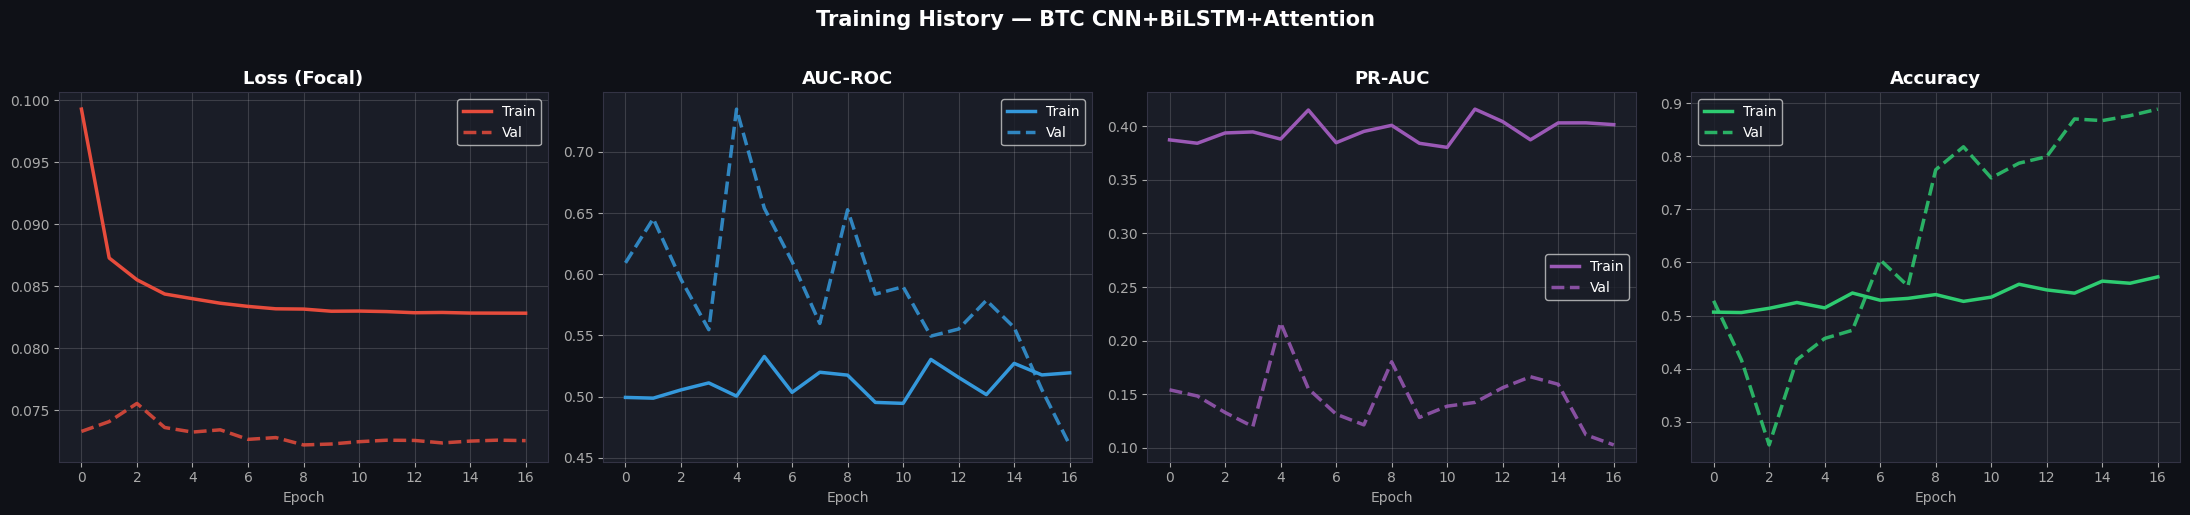

Learning curves saved.


In [11]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
fig.patch.set_facecolor("#0f1117")

PLOT_METRICS = [
    ("loss",     "Loss (Focal)",  "#e74c3c"),
    ("auc",      "AUC-ROC",       "#3498db"),
    ("pr_auc",   "PR-AUC",        "#9b59b6"),
    ("accuracy", "Accuracy",      "#2ecc71"),
]

for ax, (metric, title, color) in zip(axes, PLOT_METRICS):
    ax.set_facecolor("#1a1d27")
    ax.plot(history.history[metric], lw=2.5, color=color, label="Train")
    val_key = f"val_{metric}"
    if val_key in history.history:
        ax.plot(history.history[val_key], lw=2.5, color=color,
                linestyle="--", alpha=0.85, label="Val")
    ax.set_title(title, fontsize=13, fontweight="bold", color="white")
    ax.set_xlabel("Epoch", color="#aaaaaa")
    ax.tick_params(colors="#aaaaaa")
    ax.legend(facecolor="#1a1d27", labelcolor="white")
    ax.grid(True, alpha=0.15, color="white")
    for spine in ax.spines.values():
        spine.set_color("#333344")

plt.suptitle("Training History — BTC CNN+BiLSTM+Attention",
             fontsize=15, fontweight="bold", color="white", y=1.02)
plt.tight_layout()
plt.savefig(
    os.path.join(SAVE_DIR, "learning_curves.png"),
    dpi=120, bbox_inches="tight", facecolor="#0f1117",
)
plt.show()
print("Learning curves saved.")


## 12. Decision Threshold Optimization

Sweep thresholds [0.10, 0.92] on the **validation set** to maximize F1-macro.  
Fallback to 0.50 if the optimized threshold degrades F1-macro vs the default.

Optimal threshold : 0.51  (F1-macro=0.5700)
  F1-UP   @ 0.51 : 0.2143
  F1-DOWN @ 0.51 : 0.9257
  F1-macro @ 0.50 (baseline) : 0.4135


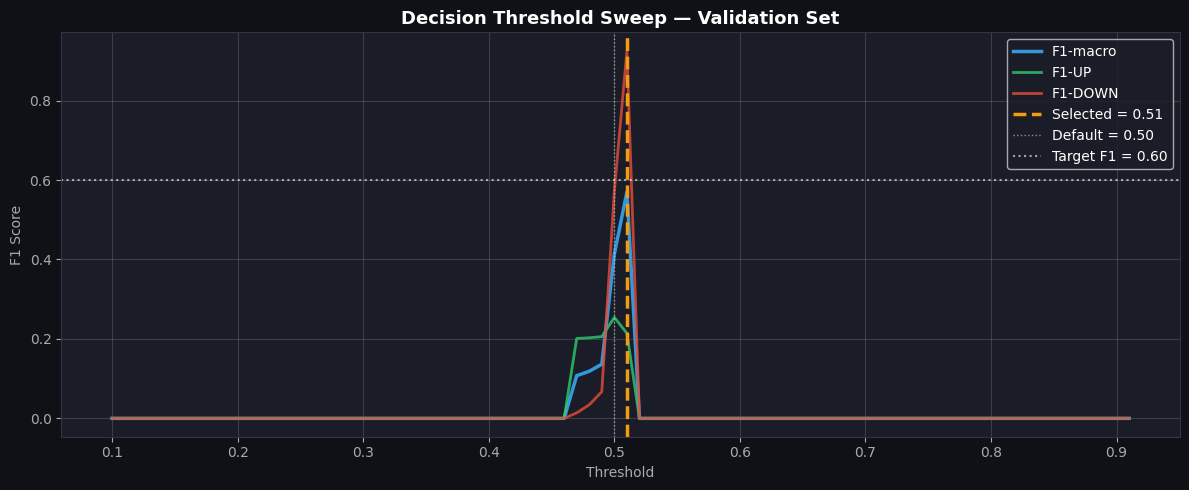

In [12]:
y_val_prob = model.predict(
    [X_text_val, tfidf_val_lsa, X_num_val], verbose=0
).flatten()

thresholds = np.arange(0.10, 0.92, 0.01)
sweep      = []

for t in thresholds:
    y_p = (y_val_prob >= t).astype(int)
    if y_p.sum() == 0 or y_p.sum() == len(y_p):
        sweep.append((t, 0.0, 0.0, 0.0))
        continue
    sweep.append((
        t,
        f1_score(y_val, y_p, average="macro",   zero_division=0),
        f1_score(y_val, y_p, pos_label=1, average="binary", zero_division=0),
        f1_score(y_val, y_p, pos_label=0, average="binary", zero_division=0),
    ))

sweep  = np.array(sweep)
best_i = int(np.argmax(sweep[:, 1]))
THRESH = sweep[best_i, 0]

f1_at_optimal = sweep[best_i, 1]
f1_at_050     = f1_score(
    y_val, (y_val_prob >= 0.50).astype(int), average="macro", zero_division=0
)

if f1_at_optimal < f1_at_050:
    print(f"Threshold {THRESH:.2f} degrades F1-macro ({f1_at_optimal:.4f}) vs 0.50 ({f1_at_050:.4f})")
    print("Reverting to threshold = 0.50")
    THRESH = 0.50
else:
    print(f"Optimal threshold : {THRESH:.2f}  (F1-macro={f1_at_optimal:.4f})")
    print(f"  F1-UP   @ {THRESH:.2f} : {sweep[best_i, 2]:.4f}")
    print(f"  F1-DOWN @ {THRESH:.2f} : {sweep[best_i, 3]:.4f}")
    print(f"  F1-macro @ 0.50 (baseline) : {f1_at_050:.4f}")

# Threshold sweep plot
fig, ax = plt.subplots(figsize=(12, 5))
fig.patch.set_facecolor("#0f1117")
ax.set_facecolor("#1a1d27")

ax.plot(sweep[:, 0], sweep[:, 1], "#3498db", lw=2.5, label="F1-macro")
ax.plot(sweep[:, 0], sweep[:, 2], "#2ecc71", lw=2.0, alpha=0.8, label="F1-UP")
ax.plot(sweep[:, 0], sweep[:, 3], "#e74c3c", lw=2.0, alpha=0.8, label="F1-DOWN")
ax.axvline(THRESH, color="#f39c12", lw=2.5, linestyle="--",
           label=f"Selected = {THRESH:.2f}")
ax.axvline(0.50, color="white",    lw=1.0, linestyle=":",  alpha=0.5,
           label="Default = 0.50")
ax.axhline(0.60, color="#ffffff",  lw=1.5, linestyle=":",  alpha=0.6,
           label="Target F1 = 0.60")

ax.set_title("Decision Threshold Sweep — Validation Set",
             fontsize=13, fontweight="bold", color="white")
ax.set_xlabel("Threshold", color="#aaaaaa")
ax.set_ylabel("F1 Score",  color="#aaaaaa")
ax.tick_params(colors="#aaaaaa")
ax.legend(facecolor="#1a1d27", labelcolor="white")
ax.grid(True, alpha=0.15, color="white")
for spine in ax.spines.values():
    spine.set_color("#333344")

plt.tight_layout()
plt.savefig(
    os.path.join(SAVE_DIR, "threshold_sweep.png"),
    dpi=120, bbox_inches="tight", facecolor="#0f1117",
)
plt.show()


## 13. Final Evaluation on Test Set

In [13]:
y_pred_prob = model.predict(
    [X_text_test, tfidf_test_lsa, X_num_test], verbose=0
).flatten()
y_pred = (y_pred_prob >= THRESH).astype(int)


def print_evaluation(y_true, y_pred, y_prob, title: str):
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    f1m = f1_score(y_true, y_pred, average="macro",    zero_division=0)
    f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    n_up   = int(y_pred.sum())
    n_down = len(y_pred) - n_up
    bar = "═" * 65
    print(bar)
    print(f"  {title}")
    print(bar)
    print(f"  Accuracy     : {acc:.4f}")
    print(f"  AUC-ROC      : {auc:.4f}  "
          f"(random=0.500 | good≥0.560 | excellent≥0.650)")
    print(f"  F1-macro     : {f1m:.4f}  "
          f"{'✓ TARGET MET (>0.60)' if f1m >= 0.60 else '✗ Target: 0.60+'}")
    print(f"  F1-weighted  : {f1w:.4f}")
    print(f"  Predictions  : {n_down} DOWN | {n_up} UP  "
          f"({n_down/(n_down+n_up):.1%} / {n_up/(n_down+n_up):.1%})")
    print()
    print(classification_report(
        y_true, y_pred,
        target_names=["DOWN (0)", "UP (1)"],
        zero_division=0,
    ))
    return auc, f1m


auc_result, f1_result = print_evaluation(
    y_test, y_pred, y_pred_prob,
    f"Test Set — Threshold {THRESH:.2f}",
)

ap = average_precision_score(y_test, y_pred_prob)
print(f"  Average Precision (PR-AUC) : {ap:.4f}")

if auc_result >= 0.65:
    print("  Excellent — robust signal captured.")
elif auc_result >= 0.56:
    print("  Good — signal present; more data would improve further.")
elif auc_result >= 0.50:
    print("  Weak — near random; consider adding more trading days.")
else:
    print("  WARNING: AUC < 0.50 — predictions may be inverted.")


═════════════════════════════════════════════════════════════════
  Test Set — Threshold 0.51
═════════════════════════════════════════════════════════════════
  Accuracy     : 0.3138
  AUC-ROC      : 0.3494  (random=0.500 | good≥0.560 | excellent≥0.650)
  F1-macro     : 0.2721  ✗ Target: 0.60+
  F1-weighted  : 0.1998
  Predictions  : 356 DOWN | 20 UP  (94.7% / 5.3%)

              precision    recall  f1-score   support

    DOWN (0)       0.29      0.95      0.45       110
      UP (1)       0.70      0.05      0.10       266

    accuracy                           0.31       376
   macro avg       0.50      0.50      0.27       376
weighted avg       0.58      0.31      0.20       376

  Average Precision (PR-AUC) : 0.6370


## 14. Evaluation Plots

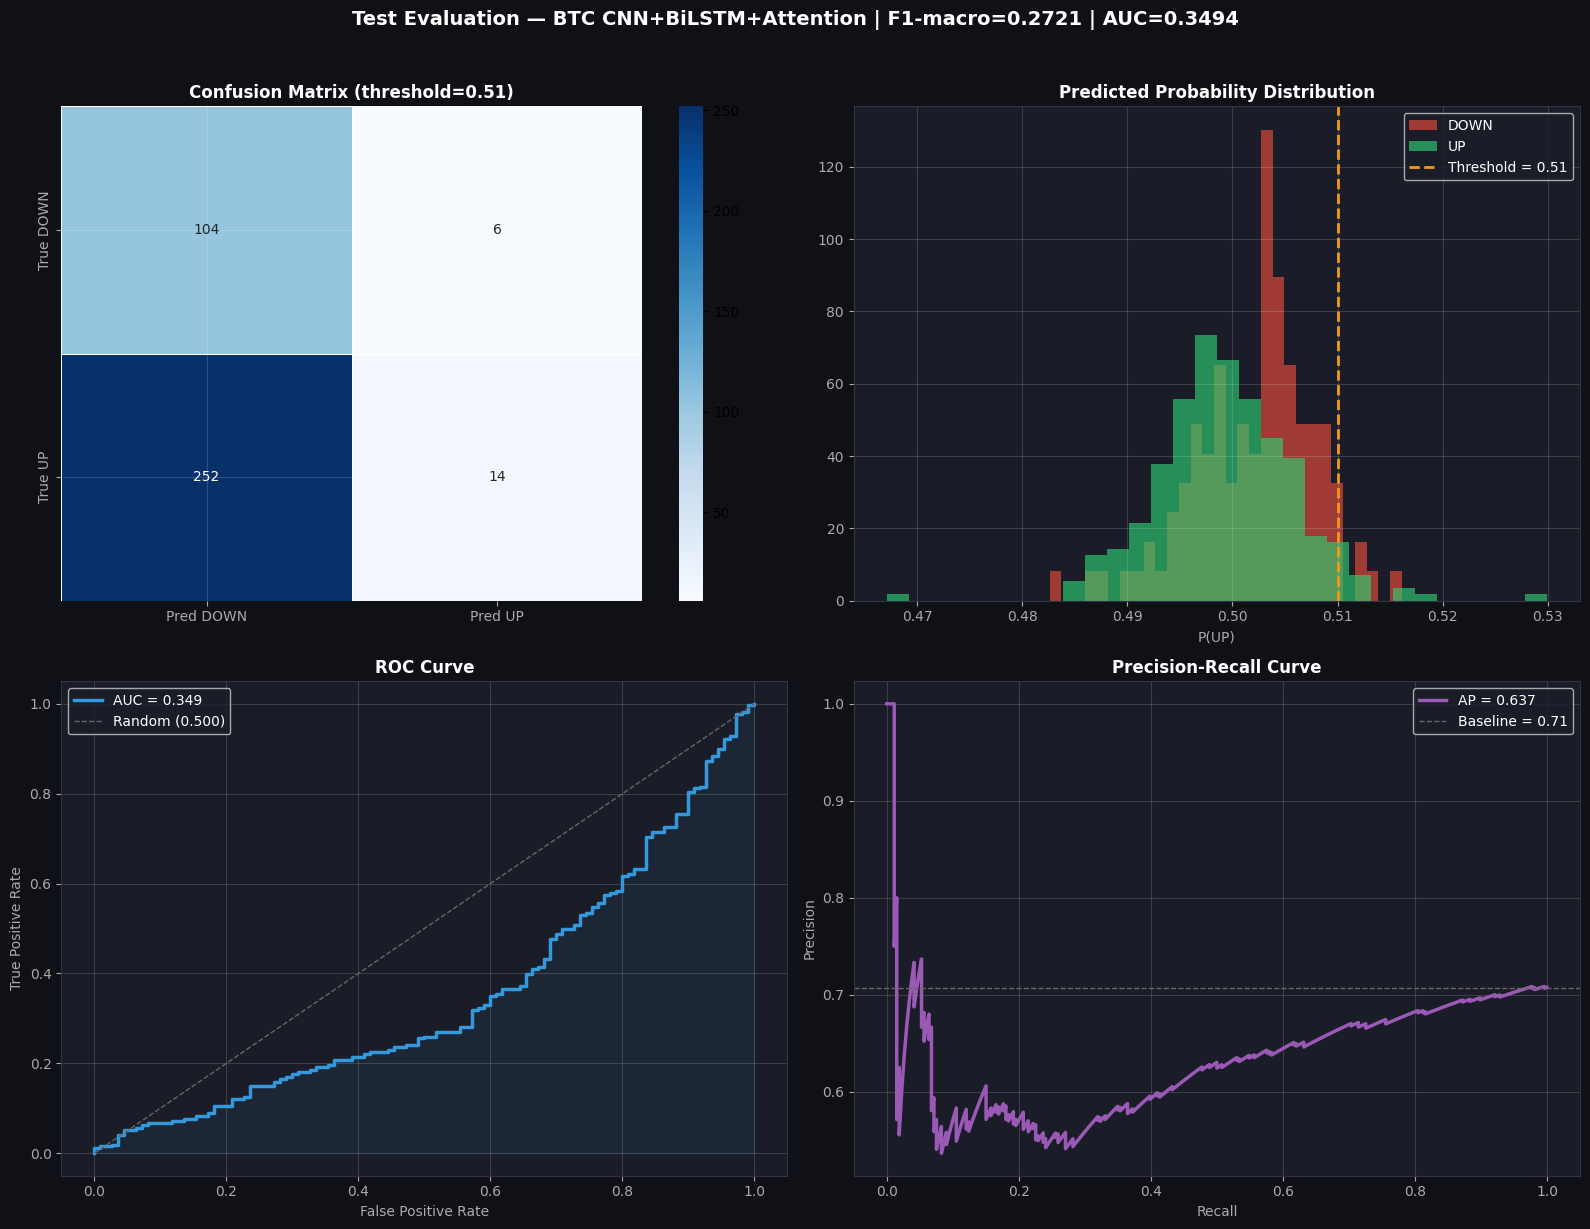

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.patch.set_facecolor("#0f1117")
for ax in axes.flat:
    ax.set_facecolor("#1a1d27")

# ── Confusion matrix ──────────────────────────────────────────────────────────
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt="d", ax=axes[0, 0], cmap="Blues",
    xticklabels=["Pred DOWN", "Pred UP"],
    yticklabels=["True DOWN", "True UP"],
    linewidths=0.5,
)
axes[0, 0].set_title(
    f"Confusion Matrix (threshold={THRESH:.2f})",
    fontsize=12, fontweight="bold", color="white",
)
axes[0, 0].tick_params(colors="#aaaaaa")

# ── Probability distribution ─────────────────────────────────────────────────
for label, color, name in [(0, "#e74c3c", "DOWN"), (1, "#2ecc71", "UP")]:
    mask = y_test == label
    axes[0, 1].hist(
        y_pred_prob[mask], bins=30, alpha=0.65,
        color=color, label=name, density=True,
    )
axes[0, 1].axvline(THRESH, color="#f39c12", lw=2, linestyle="--",
                    label=f"Threshold = {THRESH:.2f}")
axes[0, 1].set_title("Predicted Probability Distribution",
                      fontsize=12, fontweight="bold", color="white")
axes[0, 1].set_xlabel("P(UP)", color="#aaaaaa")
axes[0, 1].tick_params(colors="#aaaaaa")
axes[0, 1].legend(facecolor="#1a1d27", labelcolor="white")

# ── ROC curve ────────────────────────────────────────────────────────────────
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
axes[1, 0].plot(fpr, tpr, "#3498db", lw=2.5, label=f"AUC = {auc_result:.3f}")
axes[1, 0].plot([0, 1], [0, 1], "#666666", lw=1, linestyle="--", label="Random (0.500)")
axes[1, 0].fill_between(fpr, tpr, alpha=0.08, color="#3498db")
axes[1, 0].set_title("ROC Curve", fontsize=12, fontweight="bold", color="white")
axes[1, 0].set_xlabel("False Positive Rate", color="#aaaaaa")
axes[1, 0].set_ylabel("True Positive Rate",  color="#aaaaaa")
axes[1, 0].tick_params(colors="#aaaaaa")
axes[1, 0].legend(facecolor="#1a1d27", labelcolor="white")

# ── PR curve ─────────────────────────────────────────────────────────────────
prec, rec, _ = precision_recall_curve(y_test, y_pred_prob)
axes[1, 1].plot(rec, prec, "#9b59b6", lw=2.5, label=f"AP = {ap:.3f}")
axes[1, 1].axhline(
    y_test.mean(), color="#666666", lw=1, linestyle="--",
    label=f"Baseline = {y_test.mean():.2f}"
)
axes[1, 1].set_title("Precision-Recall Curve", fontsize=12, fontweight="bold", color="white")
axes[1, 1].set_xlabel("Recall",    color="#aaaaaa")
axes[1, 1].set_ylabel("Precision", color="#aaaaaa")
axes[1, 1].tick_params(colors="#aaaaaa")
axes[1, 1].legend(facecolor="#1a1d27", labelcolor="white")

for ax in axes.flat:
    ax.grid(True, alpha=0.15, color="white")
    for spine in ax.spines.values():
        spine.set_color("#333344")

plt.suptitle(
    f"Test Evaluation — BTC CNN+BiLSTM+Attention | F1-macro={f1_result:.4f} | AUC={auc_result:.4f}",
    fontsize=14, fontweight="bold", color="white", y=1.02,
)
plt.tight_layout()
plt.savefig(
    os.path.join(SAVE_DIR, "evaluation_plots.png"),
    dpi=120, bbox_inches="tight", facecolor="#0f1117",
)
plt.show()


## 15. Artifact Saving

In [15]:
# ── Model & preprocessors ─────────────────────────────────────────────────────
model.save(os.path.join(SAVE_DIR, "model.keras"))

with open(os.path.join(SAVE_DIR, "tokenizer.json"), "w") as fh:
    json.dump(tokenizer.to_json(), fh)

joblib.dump(scaler,       os.path.join(SAVE_DIR, "scaler.pkl"))
joblib.dump(tfidf,        os.path.join(SAVE_DIR, "tfidf.pkl"))
joblib.dump(svd,          os.path.join(SAVE_DIR, "svd.pkl"))
joblib.dump(tfidf_scaler, os.path.join(SAVE_DIR, "tfidf_scaler.pkl"))
joblib.dump(le_cat,       os.path.join(SAVE_DIR, "label_encoder_cat.pkl"))
joblib.dump(le_src,       os.path.join(SAVE_DIR, "label_encoder_src.pkl"))

# ── Config ────────────────────────────────────────────────────────────────────
config = {
    "model_version"   : "cnn_bilstm_attn_v1",
    "MAX_VOCAB"       : MAX_VOCAB,
    "MAX_LENGTH"      : MAX_LENGTH,
    "TFIDF_DIM"       : TFIDF_DIM,
    "CATEGORIES"      : CATEGORIES,
    "SOURCES"         : SOURCES,
    "CONTINUOUS_COLS" : CONTINUOUS_COLS,
    "NUM_DIM"         : int(NUM_DIM),
    "threshold"       : float(THRESH),
    "test_auc"        : round(float(auc_result), 4),
    "test_ap"         : round(float(ap), 4),
    "test_f1_macro"   : round(float(f1_result), 4),
}
with open(os.path.join(SAVE_DIR, "config.json"), "w") as fh:
    json.dump(config, fh, indent=2)

# ── Verification ──────────────────────────────────────────────────────────────
print(f"Artifacts saved to: {os.path.abspath(SAVE_DIR)}/")
print()
for fname in [
    "model.keras", "best_model.keras", "tokenizer.json",
    "scaler.pkl", "tfidf.pkl", "svd.pkl", "tfidf_scaler.pkl",
    "label_encoder_cat.pkl", "label_encoder_src.pkl", "config.json",
]:
    path = os.path.join(SAVE_DIR, fname)
    ok   = os.path.exists(path)
    size = os.path.getsize(path) / 1024 if ok else 0.0
    print(f"  {'OK' if ok else 'MISSING':<8} {fname:<35} ({size:.1f} KB)")

print()
print(f"Test AUC-ROC   : {config['test_auc']}")
print(f"Test F1-macro  : {config['test_f1_macro']}  "
      f"{'(TARGET MET)' if config['test_f1_macro'] >= 0.60 else '(below 0.60)'}")
print(f"Threshold used : {config['threshold']}")


Artifacts saved to: c:\Users\15086\Desktop\ml-dl-dashbord\dl-ml-btc\models\hybrid_cnn_bilstm/

  OK       model.keras                         (47918.1 KB)
  OK       best_model.keras                    (47918.1 KB)
  OK       tokenizer.json                      (895.1 KB)
  OK       scaler.pkl                          (1.1 KB)
  OK       tfidf.pkl                           (396.0 KB)
  OK       svd.pkl                             (7815.6 KB)
  OK       tfidf_scaler.pkl                    (2.9 KB)
  OK       label_encoder_cat.pkl               (0.6 KB)
  OK       label_encoder_src.pkl               (0.7 KB)
  OK       config.json                         (1.0 KB)

Test AUC-ROC   : 0.3494
Test F1-macro  : 0.2721  (below 0.60)
Threshold used : 0.5099999999999998


## 16. Real-Time Inference Class

In [16]:
class BTCNewsPredictor:
    """
    Real-time inference wrapper for the BTC CNN+BiLSTM+Attention model.

    Parameters
    ----------
    model_dir : str
        Path to the directory containing model.keras and all artifact files.
    """

    _DAILY_DEFAULTS = {
        "volume_news"     : 5.0,
        "avg_sentiment"   : 0.0,
        "std_sentiment"   : 0.1,
        "avg_price_change": 0.0,
        "max_severity"    : 5.0,
        "avg_severity"    : 3.0,
        "news_momentum"   : 5.0,
        "sent_momentum"   : 0.0,
        "sent_volatility" : 0.0,
        "volume_accel"    : 0.0,
        "log_price"       : np.log1p(95_000),
        "neg_news_ratio"  : 0.3,
        "pos_news_ratio"  : 0.4,
        "sentiment_range" : 0.2,
        "max_sentiment"   : 0.3,
        "min_sentiment"   : -0.1,
        "sent_trend_5d"   : 0.0,
        "price_sent_x"    : 0.0,
        "is_weekend"      : 0.0,
        "is_monday"       : 0.0,
        "is_friday"       : 0.0,
    }

    @staticmethod
    def _clean(text: str) -> str:
        text = re.sub(r"http\S+|www\S+", "", text)
        text = re.sub(r"<[^>]+>", " ", text)
        text = re.sub(r"[^a-zA-Z0-9\s'\-\$\%\.\,]", " ", text)
        return re.sub(r"\s+", " ", text).strip().lower()

    @staticmethod
    def _sentiment_label(score: float) -> str:
        if   score >  0.3: return "very_positive"
        elif score >  0.1: return "positive"
        elif score < -0.3: return "very_negative"
        elif score < -0.1: return "negative"
        else:              return "neutral"

    @staticmethod
    def _severity_label(s: int) -> str:
        if   s >= 8: return "critical_event"
        elif s >= 5: return "major_event"
        else:        return "minor_event"

    def __init__(self, model_dir: str):
        print(f"Loading model from: {model_dir}")

        with open(os.path.join(model_dir, "config.json")) as fh:
            self.cfg = json.load(fh)

        # FocalLoss must be passed in custom_objects for Keras to deserialize it
        self.model = load_model(
            os.path.join(model_dir, "model.keras"),
            custom_objects={"FocalLoss": FocalLoss},
        )
        with open(os.path.join(model_dir, "tokenizer.json")) as fh:
            self.tokenizer = tokenizer_from_json(json.load(fh))

        self.scaler       = joblib.load(os.path.join(model_dir, "scaler.pkl"))
        self.tfidf        = joblib.load(os.path.join(model_dir, "tfidf.pkl"))
        self.svd          = joblib.load(os.path.join(model_dir, "svd.pkl"))
        self.tfidf_scaler = joblib.load(os.path.join(model_dir, "tfidf_scaler.pkl"))
        self.le_cat       = joblib.load(os.path.join(model_dir, "label_encoder_cat.pkl"))
        self.le_src       = joblib.load(os.path.join(model_dir, "label_encoder_src.pkl"))
        self.thresh       = float(self.cfg.get("threshold", 0.50))

        print(f"Ready — AUC: {self.cfg['test_auc']}  |  "
              f"F1-macro: {self.cfg['test_f1_macro']}  |  "
              f"Threshold: {self.thresh:.2f}")

    def predict(
        self,
        text            : str,
        sentiment_score : float = 0.0,
        category        : str   = "OTHER",
        source          : str   = "Unknown",
        price_change_24h: float = 0.0,
        severity        : int   = 1,
        price           : float = 95_000.0,
        **daily_kw,
    ) -> dict:
        """
        Predict next-day BTC price direction for a single news article.

        Returns
        -------
        dict  {direction, probability, threshold, confidence, signal}
        """
        clean_text = self._clean(text)
        slbl       = self._sentiment_label(sentiment_score)
        sevlbl     = self._severity_label(severity)
        enriched   = f"{clean_text} {category.lower()} {slbl} {sevlbl}"

        # ── Text sequence ──────────────────────────────────────────────────
        X_text = pad_sequences(
            self.tokenizer.texts_to_sequences([enriched]),
            maxlen=self.cfg["MAX_LENGTH"], padding="post", truncating="post",
        )

        # ── TF-IDF LSA ─────────────────────────────────────────────────────
        tfidf_raw = self.tfidf.transform([clean_text])
        tfidf_lsa = self.tfidf_scaler.transform(
            self.svd.transform(tfidf_raw)
        ).astype(np.float32)

        # ── Numeric features ───────────────────────────────────────────────
        cat_list = self.cfg["CATEGORIES"]
        src_list = self.cfg["SOURCES"]
        cat_safe = category if category in cat_list else "OTHER"
        src_safe = source   if source   in src_list else "Other"

        daily_vals = {**self._DAILY_DEFAULTS, **daily_kw}
        cont_cols  = self.cfg["CONTINUOUS_COLS"]

        # Build the continuous feature vector matching training order
        per_article = {
            "sentiment_score" : sentiment_score,
            "price_change_24h": price_change_24h,
            "severity"        : float(severity),
        }
        cont_row = np.array(
            [[per_article.get(c, daily_vals.get(c, 0.0)) for c in cont_cols]],
            dtype=np.float32,
        )
        cont_scaled = self.scaler.transform(cont_row)

        cat_ohe = tf.keras.utils.to_categorical(
            [self.le_cat.transform([cat_safe])[0]], num_classes=len(cat_list)
        )
        src_ohe = tf.keras.utils.to_categorical(
            [self.le_src.transform([src_safe])[0]], num_classes=len(src_list)
        )
        X_num = np.hstack([cont_scaled, cat_ohe, src_ohe]).astype(np.float32)

        # ── Inference ──────────────────────────────────────────────────────
        prob = float(self.model.predict([X_text, tfidf_lsa, X_num], verbose=0)[0][0])

        direction  = "UP" if prob >= self.thresh else "DOWN"
        confidence = abs(prob - self.thresh) / max(self.thresh, 1.0 - self.thresh)

        return {
            "direction"  : direction,
            "probability": round(prob, 4),
            "threshold"  : self.thresh,
            "confidence" : round(confidence, 4),
            "signal"     : f"{direction} | P(UP)={prob:.1%}",
        }


print("BTCNewsPredictor class defined")
print("Usage:")
print("  predictor = BTCNewsPredictor('../models/hybrid_cnn_bilstm')")
print("  result = predictor.predict(")
print("      text='SEC approves Bitcoin ETF',")
print("      sentiment_score=0.8, category='REGULATORY', severity=9")
print("  )")


BTCNewsPredictor class defined
Usage:
  predictor = BTCNewsPredictor('../models/hybrid_cnn_bilstm')
  result = predictor.predict(
      text='SEC approves Bitcoin ETF',
      sentiment_score=0.8, category='REGULATORY', severity=9
  )


## 17. FastAPI Skeleton

In [17]:
API_CODE = '''
#!/usr/bin/env python3
"""
api.py — FastAPI deployment for BTC News Impact Predictor
Install : pip install fastapi uvicorn
Run     : uvicorn api:app --reload --host 0.0.0.0 --port 8000
"""

from __future__ import annotations

import time
from typing import Optional

from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field

from btc_predictor import BTCNewsPredictor, FocalLoss  # noqa: F401

app = FastAPI(title="BTC News Impact Predictor", version="2.0")
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_methods=["*"],
    allow_headers=["*"],
)

predictor = BTCNewsPredictor("./models/hybrid_cnn_bilstm")


class NewsRequest(BaseModel):
    text             : str
    sentiment_score  : float           = Field(default=0.0, ge=-1.0, le=1.0)
    category         : str             = Field(default="OTHER")
    source           : str             = Field(default="Unknown")
    price_change_24h : float           = Field(default=0.0)
    severity         : int             = Field(default=1, ge=1, le=10)
    price            : float           = Field(default=95_000.0)
    # Optional daily context
    volume_news      : Optional[float] = 5.0
    avg_sentiment    : Optional[float] = 0.0
    std_sentiment    : Optional[float] = 0.1
    avg_price_change : Optional[float] = 0.0
    max_severity     : Optional[float] = 5.0
    avg_severity     : Optional[float] = 3.0
    news_momentum    : Optional[float] = 5.0
    sent_momentum    : Optional[float] = 0.0
    sent_volatility  : Optional[float] = 0.0
    volume_accel     : Optional[float] = 0.0


@app.get("/")
def health():
    return {
        "status" : "running",
        "model"  : predictor.cfg.get("model_version"),
        "auc"    : predictor.cfg.get("test_auc"),
        "f1"     : predictor.cfg.get("test_f1_macro"),
    }


@app.post("/predict")
def predict(req: NewsRequest):
    t0     = time.time()
    result = predictor.predict(**req.model_dump())
    return {**result, "latency_ms": round((time.time() - t0) * 1000, 1)}
'''

api_path = os.path.join(SAVE_DIR, "api.py")
with open(api_path, "w") as fh:
    fh.write(API_CODE)

print(f"FastAPI skeleton saved to: {api_path}")
print("Start with: uvicorn api:app --reload --host 0.0.0.0 --port 8000")


FastAPI skeleton saved to: ../models/hybrid_cnn_bilstm\api.py
Start with: uvicorn api:app --reload --host 0.0.0.0 --port 8000
